#Image Segmentation

## Imports

In [1]:
from os import listdir
from os import path
from PIL import Image as PImage
from PIL import ImageColor as PColor
from random import randint
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
# from MLalgorithms.clustering_validation import Fmeasure,ConditionalEntropy
from sklearn.metrics.cluster import contingency_matrix
# from sklearn.cluster import KMeans
from google.colab import drive
import math
from collections import Counter

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [60]:
pip install colormath

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39407 sha256=db841e356db7c057d2adddb2ad0f51c87f88bed9f3468433d700632f7c138838
  Stored in directory: /root/.cache/pip/wheels/1a/d7/a7/458a4632ccc8bfe436f5e9db9fef1aa84e5d243a1b4b4c7b59
Successfully built colormath


In [61]:
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

## Download the Dataset and Understand the Format

In [3]:
images_path = "/content/drive/MyDrive/Pattern Recognition/Image Segmentation/dataset/images"
groundtruth_path = "/content/drive/MyDrive/Pattern Recognition/Image Segmentation/dataset/ground_truth"

In [62]:
def loadImages(images_path, groundtruth_path):
  train_path = images_path + "/train"
  groundtruth_train_path = groundtruth_path + "/train"
  images = []
  truths = []

  for image in sorted(listdir(train_path)):
    images.append(np.array(PImage.open(train_path+"/"+image)))

  for truth in sorted(listdir(groundtruth_train_path)):
    truths.append(scipy.io.loadmat(groundtruth_train_path + "/" + truth))

  train_img = np.array(images)
  train_gt = np.array(truths)

  print(train_img.shape)
  print(train_gt.shape)
  return train_img, truths

In [114]:
print(sorted(listdir(images_path + "/train")).index("55067.jpg"))

173


In [63]:
images, truths = loadImages(images_path, groundtruth_path)

(200,)
(200,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [53]:
print(images[0].shape)


(321, 481, 3)


In [54]:
print(truths[0]['groundTruth'].shape)
print(truths[0]['groundTruth'][0].shape)
print(truths[0]['groundTruth'][0][0].shape)
print(truths[0]['groundTruth'][0][0][0].shape)
print(truths[0]['groundTruth'][0][0][0][0].shape)
print(truths[0]['groundTruth'][0][0][0][0][0].shape)

(1, 5)
(5,)
(1, 1)
(1,)
()
(321, 481)


In [16]:
print(truths[0]['groundTruth'][0][1][0][0][0])

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 5 5 5]
 [1 1 1 ... 5 5 5]
 [1 1 1 ... 5 5 5]]


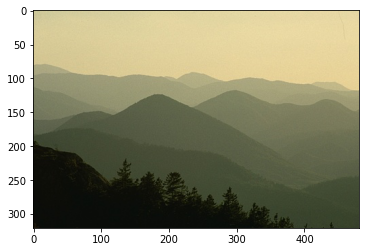

In [115]:
plt.imshow(images[173]);

Num of Clusters: 18


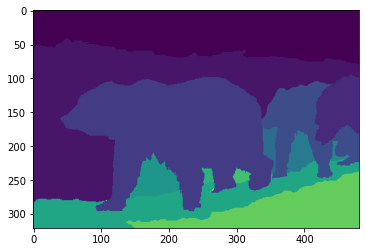

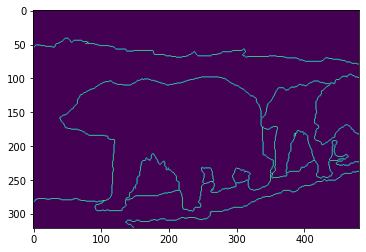

Num of Clusters: 5


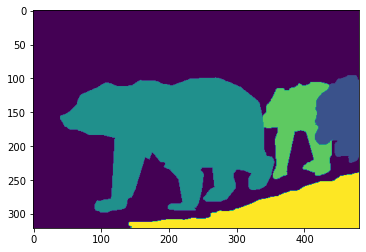

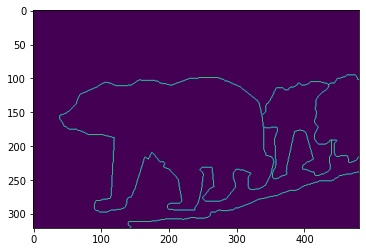

Num of Clusters: 13


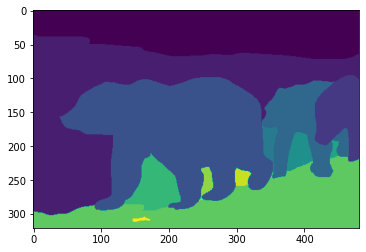

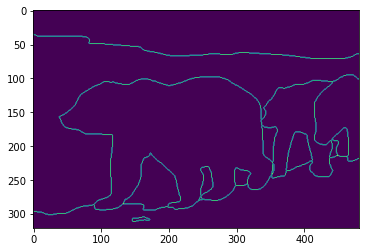

Num of Clusters: 16


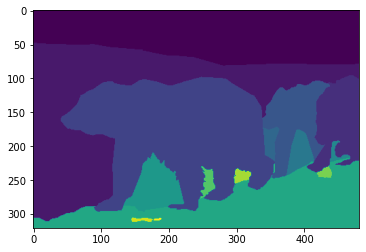

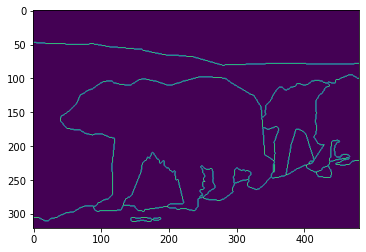

Num of Clusters: 30


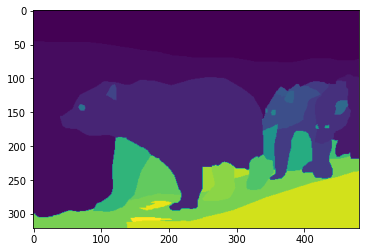

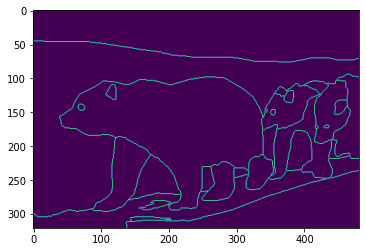

Num of Clusters: 16


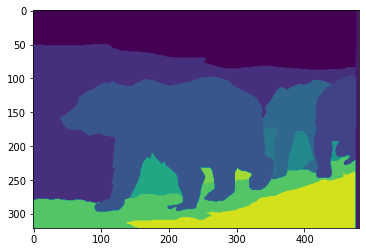

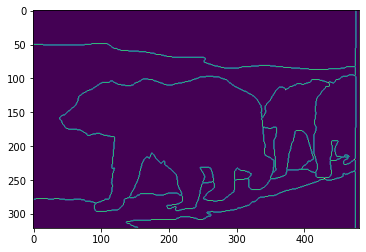

In [122]:
for i in range(truths[0]['groundTruth'][0].shape[0]):
  print("Num of Clusters: " + str(max(map(max, truths[0]['groundTruth'][0][i][0][0][0]))))
  for j in range(2):
    plt.imshow(truths[0]['groundTruth'][0][i][0][0][j])
    plt.show()
  

## Segmentation using K-Means

In [75]:
def CIELabDelta(data, centeroid):
  color1_rgb = sRGBColor(data[0], data[1], data[2]);
  color2_rgb = sRGBColor(centeroid[0], centeroid[1], centeroid[2]);

  color1_lab = convert_color(color1_rgb, LabColor);
  color2_lab = convert_color(color2_rgb, LabColor);
  delta_e = delta_e_cie2000(color1_lab, color2_lab);
  return delta_e

In [120]:
def Kmeans(data, num_clusters = 2, tolerance=0.0001, max_iter = 300, CIELAB = False):
    iter_num = 0
    n = data.shape[0] # 154401
    c = data.shape[1] # 3

    mean = np.mean(data, axis = 0) # 154401
    std = np.std(data, axis = 0)
    centroids = np.random.randn(num_clusters,c)*std + mean # 2 x 3
        
    old_centroids = np.zeros(centroids.shape)  # 2 x 3
    new_centroids = deepcopy(centroids)  # 2 x 3
    error = np.linalg.norm(new_centroids - old_centroids)
    clusters = np.zeros(n) # 154401
    distances = np.zeros((n,num_clusters)) # 154401 x 2
    while error > tolerance and iter_num < max_iter:
        iter_num += 1
        for i in range(num_clusters):
            distances[:,i] = np.linalg.norm(data - new_centroids[i], axis=1)
        clusters = np.argmin(distances, axis = 1)
        old_centroids = deepcopy(new_centroids)
        for i in range(num_clusters):
            if not data[clusters == i].any():
                new_centroids[i] = np.random.randn(1,c)*std + mean
                continue
            new_centroids[i] = np.mean(data[clusters == i], axis=0)
        error = np.linalg.norm(new_centroids - old_centroids)
        if iter_num == 2 :
          break
        
    return new_centroids,clusters,error,iter_num

In [136]:
def colorImage(image, clusters, num_clusters):
  colors = [np.array([68,1,84]), np.array([56,86,139]), np.array([83,197,103]), np.array([210,225,27]), np.array([48,103,141])]
  # colors = []
  for i in range(len(colors),num_clusters):
    colors.append(np.array([randint(0, 255),randint(0, 255),randint(0, 255)]))
  for i in range(len(clusters)):
      image[i] = colors[clusters[i]]
  # plt.imshow(image.reshape(321,481,3).astype('uint8'))
  # plt.figure()
  return image.reshape(321,481,3).astype('uint8')


In [103]:
flat = np.zeros(154401*3*200).reshape(200,154401,3)
for i in range(len(images)):
  flat[i] = images[i].flatten().reshape(-1,3)


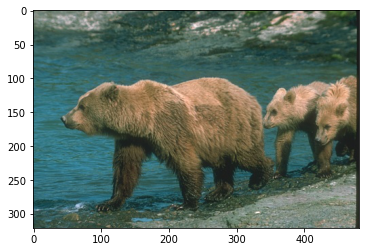

In [121]:
plt.imshow(flat[0].reshape(321,481,3).astype('uint8'))

In [149]:
K = [3,5,6,7,9]
clustered_images = []
clustered_colored_images = []
image_nums = []
for i in range(0,25,5):
  image_nums.append(i)
  for k in K:
    centers, clusters, err, itr = Kmeans(flat[i], num_clusters = k)
    clustered_images.append(clusters)
    clustered_colored_images.append(colorImage(deepcopy(flat[i]), clusters, k))
    # print(f"Clusters at K = {k}")    
    # print(Counter(clusters))
    # plt.imshow(images[i])
    # plt.show()

## Big Picture

### Select 5 Images

Original Image


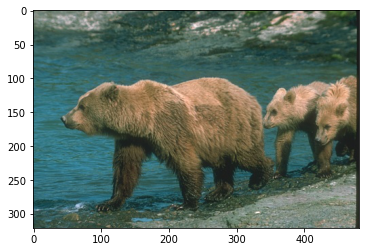

Clusters at K = 3
Counter({0: 73180, 1: 48209, 2: 33012})


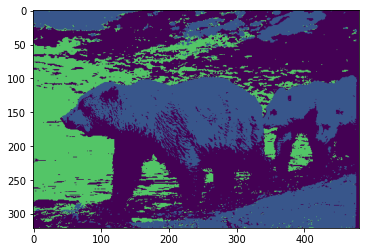

Clusters at K = 5
Counter({3: 81906, 4: 33490, 1: 26832, 2: 11613, 0: 560})


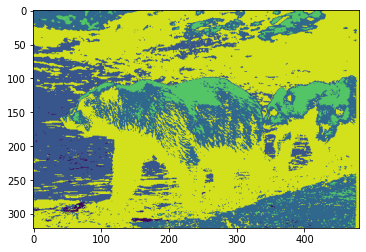

Clusters at K = 6
Counter({1: 60835, 0: 32312, 3: 29765, 4: 22470, 5: 8682, 2: 337})


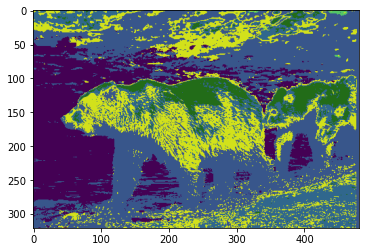

Clusters at K = 7
Counter({5: 47663, 0: 35889, 2: 16748, 3: 14876, 6: 14759, 4: 13639, 1: 10827})


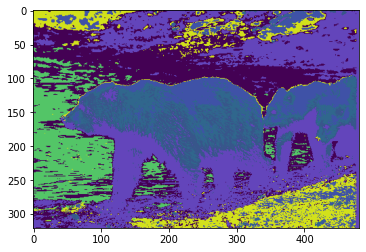

Clusters at K = 9
Counter({0: 41693, 3: 30727, 6: 27630, 4: 21336, 7: 13305, 8: 10409, 1: 5256, 5: 4045})


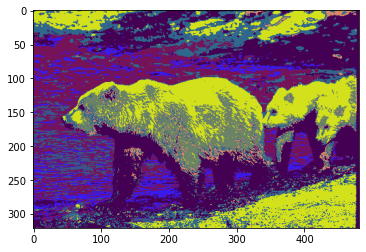

Ground Truth
Num of Clusters: 18


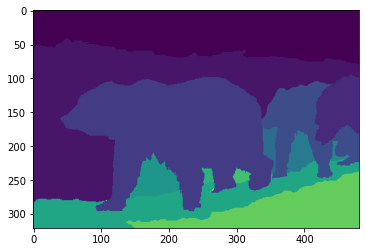

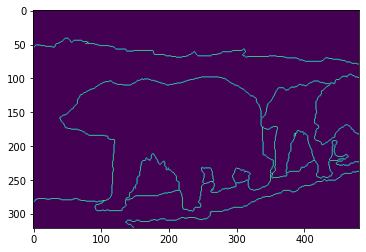

Num of Clusters: 5


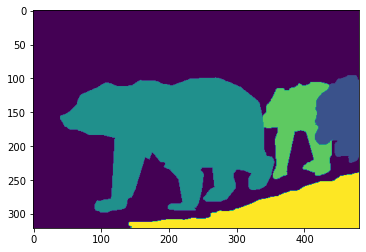

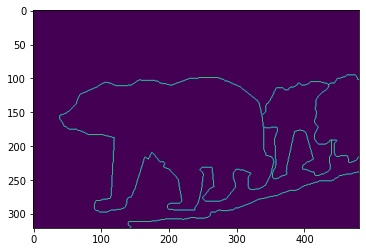

Num of Clusters: 13


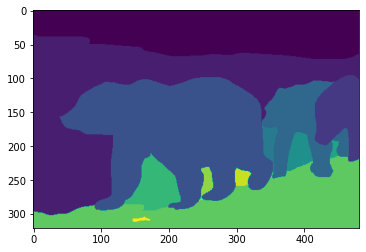

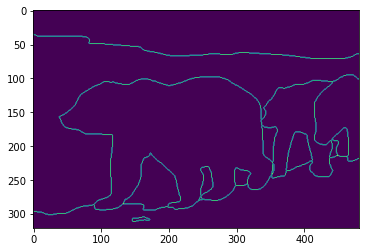

Num of Clusters: 16


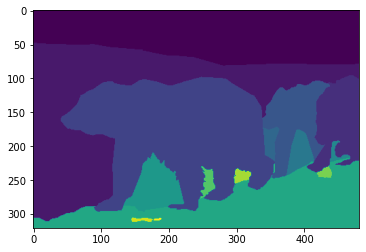

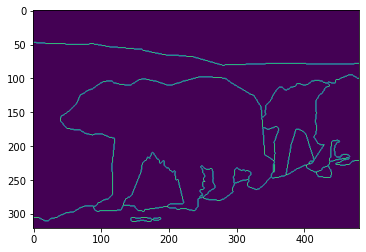

Num of Clusters: 30


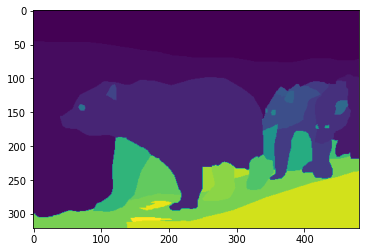

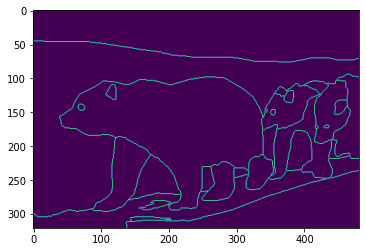

Num of Clusters: 16


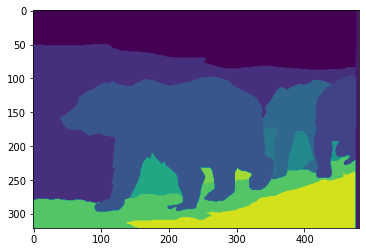

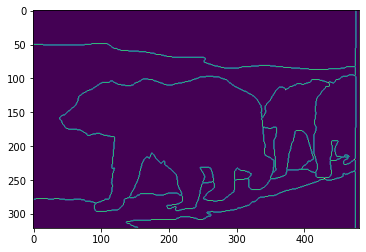

In [155]:
count = 0
print("Original Image")
plt.imshow(images[image_nums[0]])
plt.show()

for k in K:
  print(f"Clusters at K = {k}")
  print(Counter(clustered_images[count]))
  plt.imshow(clustered_colored_images[count])
  plt.show()
  count += 1

print("Ground Truth")
for i in range(truths[image_nums[0]]['groundTruth'][0].shape[0]):
  print("Num of Clusters: " + str(max(map(max, truths[0]['groundTruth'][0][i][0][0][0]))))
  for j in range(2):
    plt.imshow(truths[image_nums[0]]['groundTruth'][0][i][0][0][j])
    plt.show()

Original Image


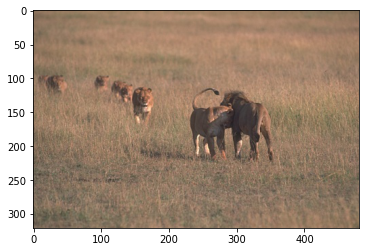

Clusters at K = 3
Counter({2: 79184, 0: 57468, 1: 17749})


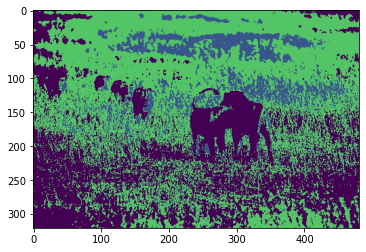

Clusters at K = 5
Counter({4: 91971, 1: 36295, 2: 21039, 0: 5096})


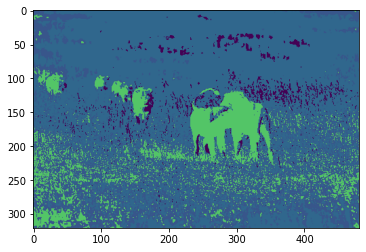

Clusters at K = 6
Counter({4: 51348, 3: 44520, 5: 24304, 1: 20947, 2: 11748, 0: 1534})


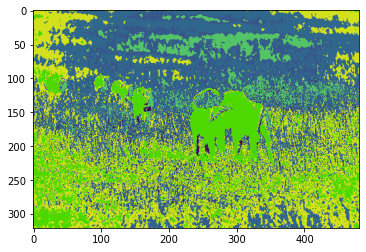

Clusters at K = 7
Counter({4: 61297, 5: 43464, 0: 21918, 6: 16551, 1: 7826, 3: 2393, 2: 952})


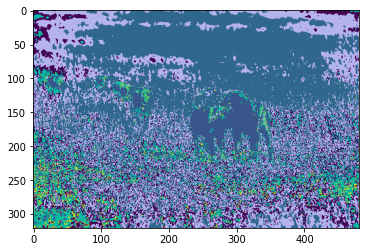

Clusters at K = 9
Counter({1: 44574, 0: 35794, 2: 31830, 3: 24182, 7: 13513, 8: 2574, 6: 1314, 4: 591, 5: 29})


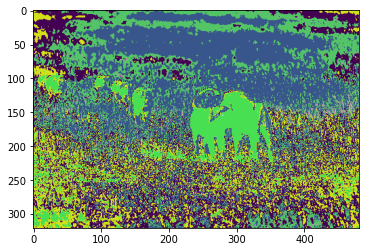

Ground Truth
Num of Clusters: 18


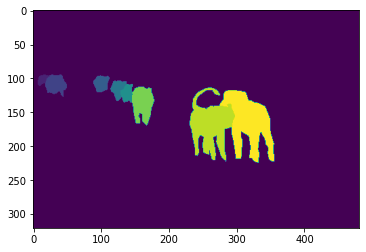

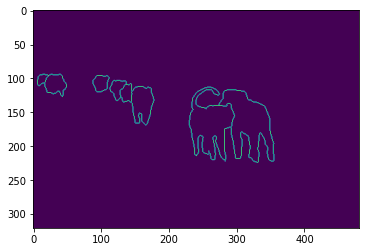

Num of Clusters: 5


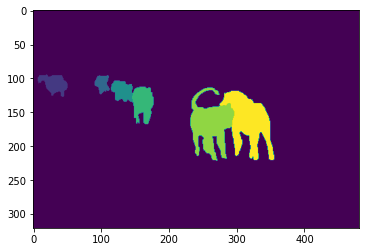

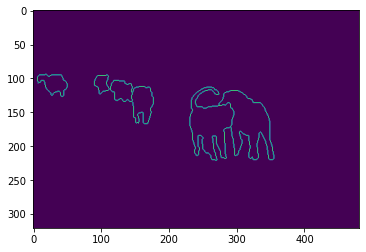

Num of Clusters: 13


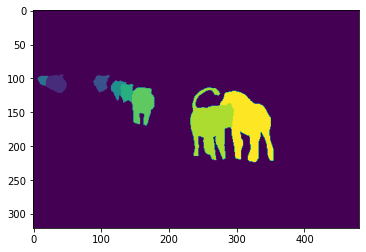

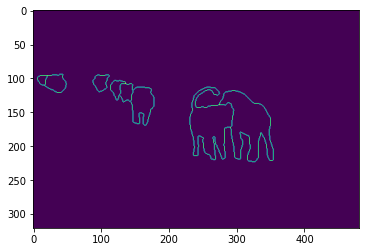

Num of Clusters: 16


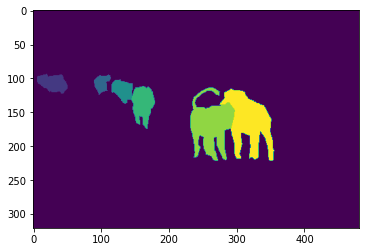

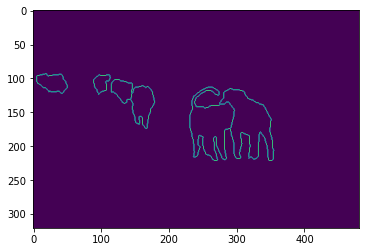

Num of Clusters: 30


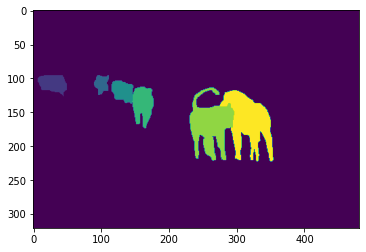

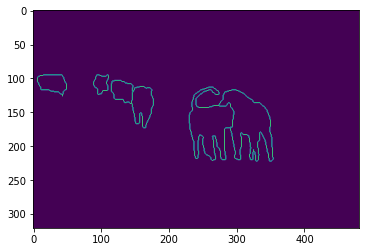

Num of Clusters: 16


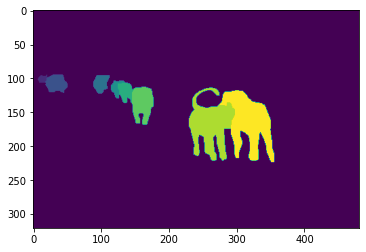

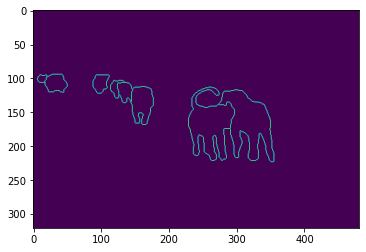

In [156]:
print("Original Image")
plt.imshow(images[image_nums[1]])
plt.show()

count = 5
for k in K:
  print(f"Clusters at K = {k}")
  print(Counter(clustered_images[count]))
  plt.imshow(clustered_colored_images[count])
  plt.show()
  count += 1

print("Ground Truth")
for i in range(truths[image_nums[1]]['groundTruth'][0].shape[0]):
  print("Num of Clusters: " + str(max(map(max, truths[0]['groundTruth'][0][i][0][0][0]))))
  for j in range(2):
    plt.imshow(truths[image_nums[1]]['groundTruth'][0][i][0][0][j])
    plt.show()

Original Image


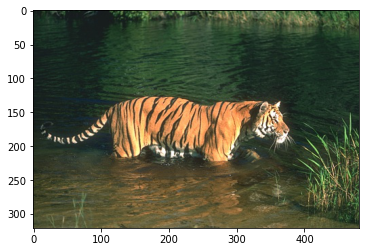

Clusters at K = 3
Counter({2: 85043, 0: 41602, 1: 27756})


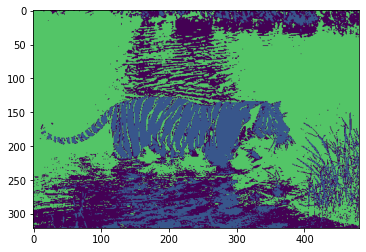

Clusters at K = 5
Counter({4: 82628, 2: 45555, 0: 20940, 1: 2840, 3: 2438})


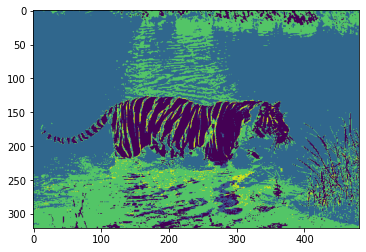

Clusters at K = 6
Counter({1: 59326, 2: 37027, 0: 30778, 5: 15828, 3: 9267, 4: 2175})


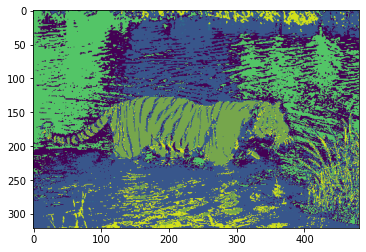

Clusters at K = 7
Counter({6: 45648, 3: 41574, 5: 34911, 4: 16802, 1: 9101, 0: 5461, 2: 904})


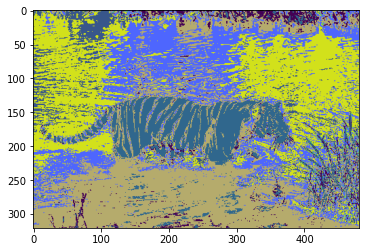

Clusters at K = 9
Counter({5: 59438, 3: 29425, 8: 26734, 0: 11214, 6: 10733, 1: 9965, 7: 6795, 4: 97})


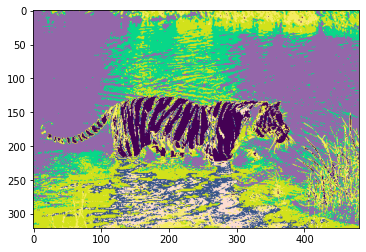

Ground Truth
Num of Clusters: 18


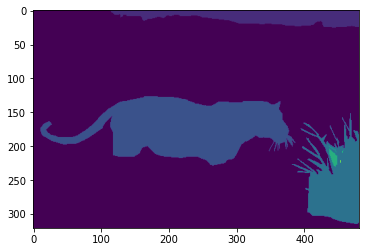

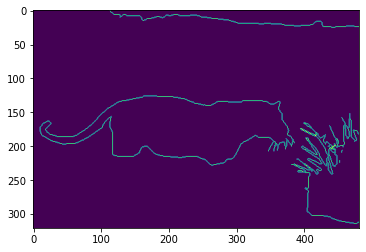

Num of Clusters: 5


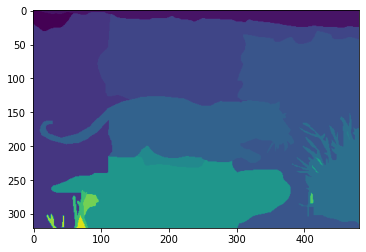

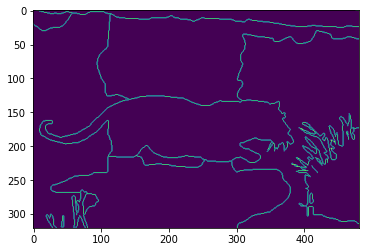

Num of Clusters: 13


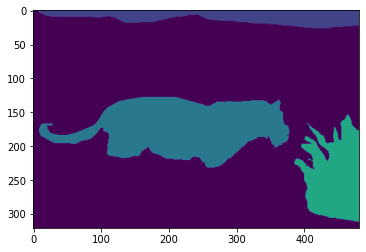

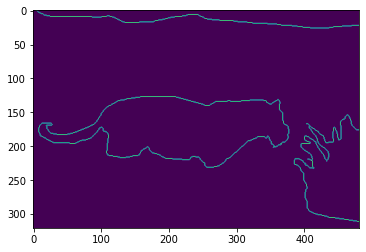

Num of Clusters: 16


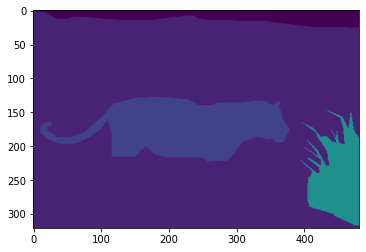

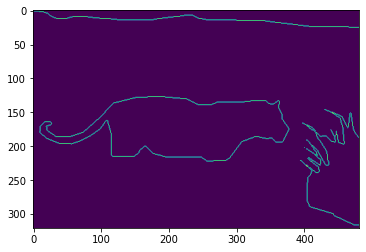

Num of Clusters: 30


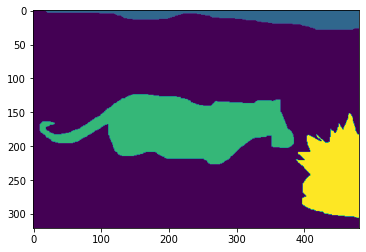

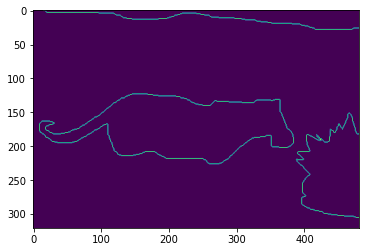

In [157]:
print("Original Image")
plt.imshow(images[image_nums[2]])
plt.show()

count = 10
for k in K:
  print(f"Clusters at K = {k}")
  print(Counter(clustered_images[count]))
  plt.imshow(clustered_colored_images[count])
  plt.show()
  count += 1

print("Ground Truth")
for i in range(truths[image_nums[2]]['groundTruth'][0].shape[0]):
  print("Num of Clusters: " + str(max(map(max, truths[0]['groundTruth'][0][i][0][0][0]))))
  for j in range(2):
    plt.imshow(truths[image_nums[2]]['groundTruth'][0][i][0][0][j])
    plt.show()

Original Image


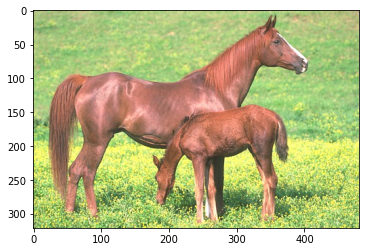

Clusters at K = 3
Counter({2: 59914, 0: 59514, 1: 34973})


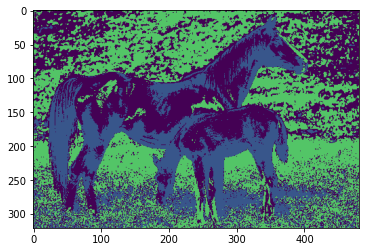

Clusters at K = 5
Counter({1: 74736, 2: 35616, 3: 20104, 4: 19538, 0: 4407})


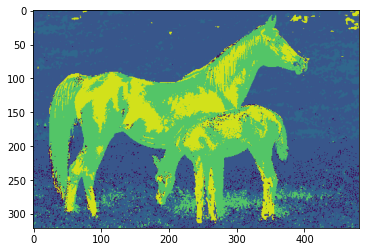

Clusters at K = 6
Counter({2: 60486, 4: 29379, 5: 21508, 1: 18138, 3: 15307, 0: 9583})


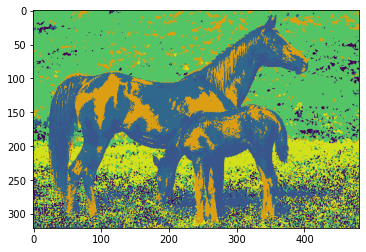

Clusters at K = 7
Counter({2: 48734, 4: 33821, 3: 22780, 5: 22269, 6: 15015, 1: 7790, 0: 3992})


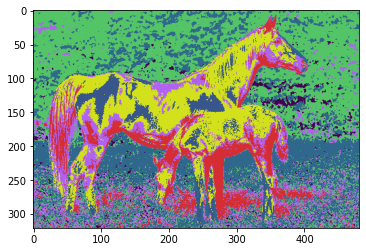

Clusters at K = 9
Counter({4: 47503, 2: 29424, 3: 20677, 6: 19126, 8: 16229, 7: 7794, 1: 7263, 5: 5413, 0: 972})


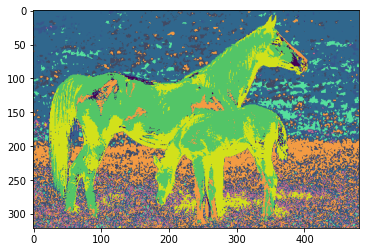

Ground Truth
Num of Clusters: 18


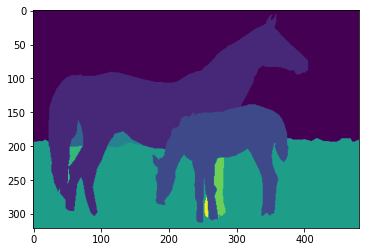

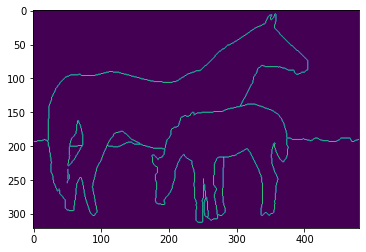

Num of Clusters: 5


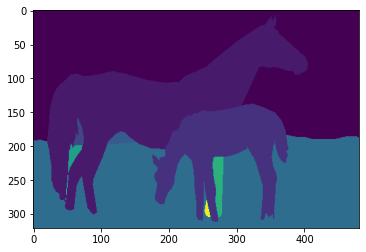

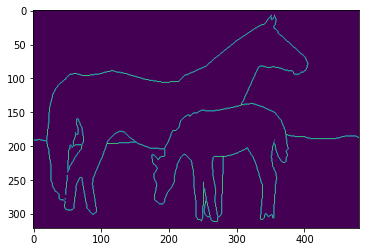

Num of Clusters: 13


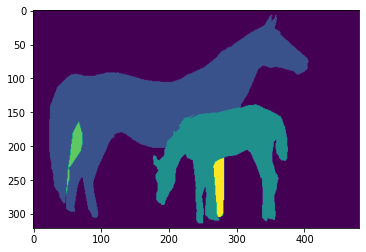

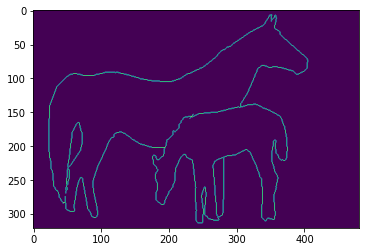

Num of Clusters: 16


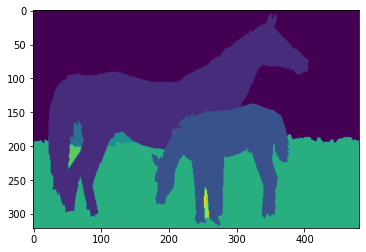

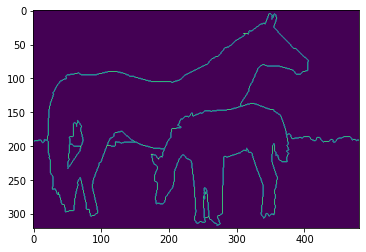

Num of Clusters: 30


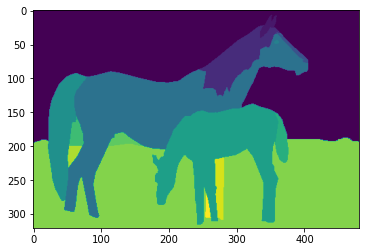

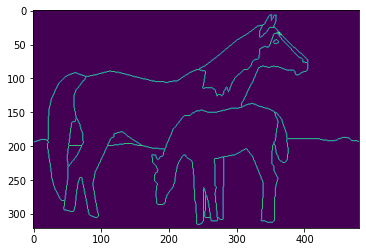

Num of Clusters: 16


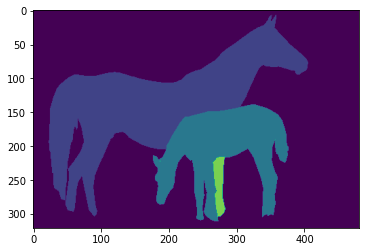

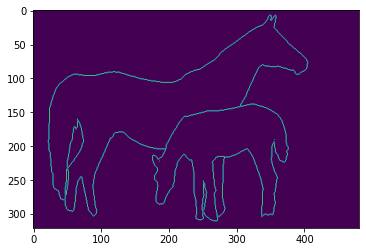

In [158]:
print("Original Image")
plt.imshow(images[image_nums[3]])
plt.show()

count = 15
for k in K:
  print(f"Clusters at K = {k}")
  print(Counter(clustered_images[count]))
  plt.imshow(clustered_colored_images[count])
  plt.show()
  count += 1

print("Ground Truth")
for i in range(truths[image_nums[3]]['groundTruth'][0].shape[0]):
  print("Num of Clusters: " + str(max(map(max, truths[0]['groundTruth'][0][i][0][0][0]))))
  for j in range(2):
    plt.imshow(truths[image_nums[3]]['groundTruth'][0][i][0][0][j])
    plt.show()

Original Image


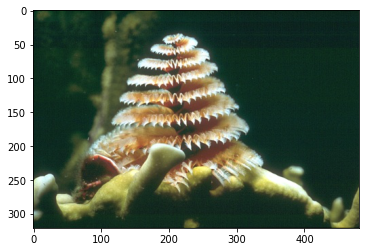

Clusters at K = 3
Counter({0: 127530, 2: 24817, 1: 2054})


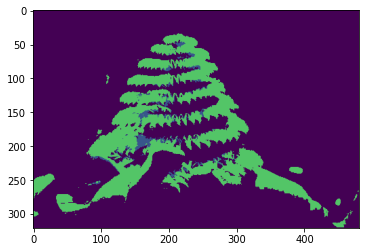

Clusters at K = 5
Counter({0: 95786, 2: 38206, 1: 18634, 3: 1764, 4: 11})


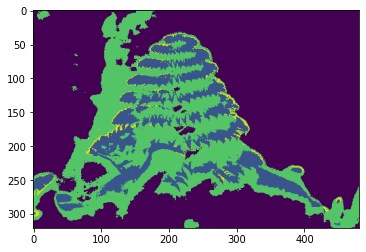

Clusters at K = 6
Counter({5: 86025, 2: 28832, 0: 18054, 3: 17443, 4: 4047})


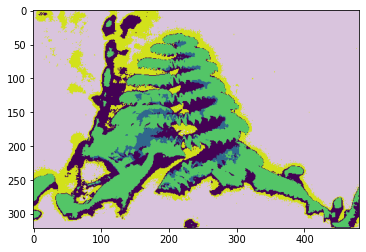

Clusters at K = 7
Counter({4: 100600, 2: 16267, 0: 16241, 6: 11044, 1: 7864, 5: 1541, 3: 844})


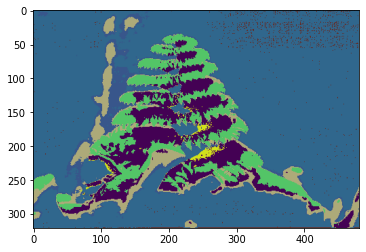

Clusters at K = 9
Counter({8: 94769, 5: 19875, 1: 18676, 0: 12901, 2: 7894, 4: 273, 3: 13})


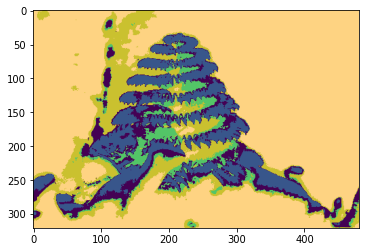

Ground Truth
Num of Clusters: 18


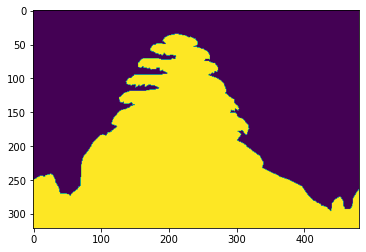

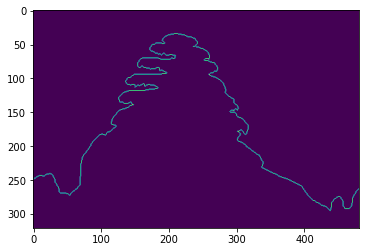

Num of Clusters: 5


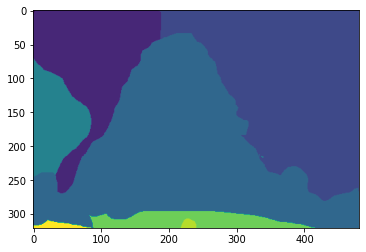

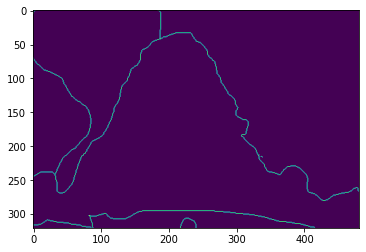

Num of Clusters: 13


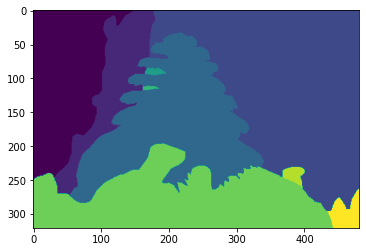

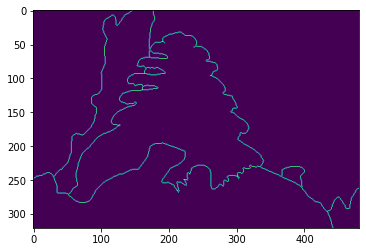

Num of Clusters: 16


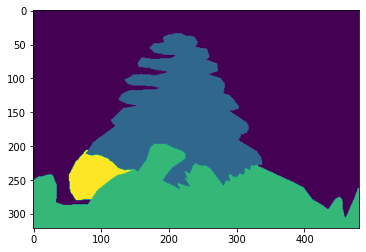

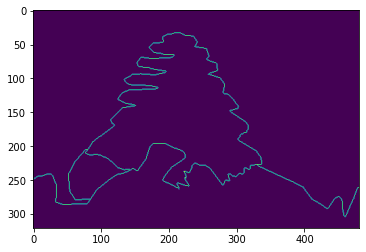

Num of Clusters: 30


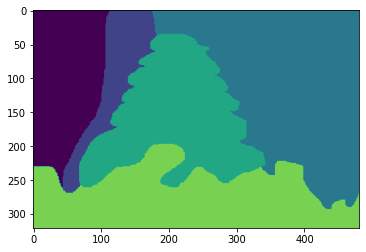

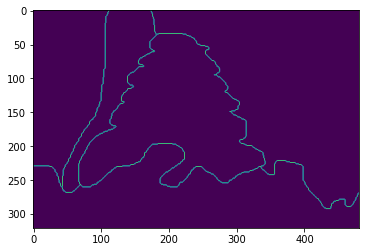

In [159]:
print("Original Image")
plt.imshow(images[image_nums[4]])
plt.show()

count = 20
for k in K:
  print(f"Clusters at K = {k}")
  print(Counter(clustered_images[count]))
  plt.imshow(clustered_colored_images[count])
  plt.show()
  count += 1

print("Ground Truth")
for i in range(truths[image_nums[4]]['groundTruth'][0].shape[0]):
  print("Num of Clusters: " + str(max(map(max, truths[0]['groundTruth'][0][i][0][0][0]))))
  for j in range(2):
    plt.imshow(truths[image_nums[4]]['groundTruth'][0][i][0][0][j])
    plt.show()